<a href="https://colab.research.google.com/github/smiledinisa/pytorch_learning/blob/master/TRANSFER_LEARNING_FOR_COMPUTER_VISION_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [5]:
%%shell 
wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
unzip hymenoptera_data.zip

--2020-08-10 08:49:59--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 143.204.226.98, 143.204.226.56, 143.204.226.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|143.204.226.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  29.4MB/s    in 1.5s    

2020-08-10 08:50:02 (29.4 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera

In [13]:
# Data augmentation(数据增强) an normalization for trainning 
# Just normalization  for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               
    ])
}

data_dir = '/content/drive/My Drive/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
          for x in ['train', 'val']}

dataloaders = { x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
          for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes#????

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
 

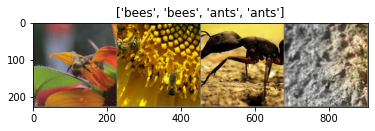

In [8]:
# visualize a few images
def imshow(inp, title=None):
  """ imshow for tensor"""
 
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated


inputs,classes = next(iter(dataloaders['train'])) # one batch.
out = torchvision.utils.make_grid(inputs)  #make a grid from batch.

imshow(out, title=[class_names[x] for x in classes])

In [9]:
# trainning the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'): #如果条件为真，则可以求导，如果为假则不求导。
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #output ??????????????
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()#========????

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
# Visualizing the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)#___________________???

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training) #???
                    return
        model.train(mode=was_training)#????


In [11]:
# Finetuning the convnet

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) #没过7次，更新一次lr


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5862 Acc: 0.7787
val Loss: 0.3103 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.4967 Acc: 0.7992
val Loss: 0.2551 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.6786 Acc: 0.7582
val Loss: 0.7034 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.5268 Acc: 0.7787
val Loss: 0.3390 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4229 Acc: 0.8361
val Loss: 0.2113 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5292 Acc: 0.8033
val Loss: 0.3520 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.3646 Acc: 0.8320
val Loss: 0.2364 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4310 Acc: 0.8238
val Loss: 0.2251 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3680 Acc: 0.8402
val Loss: 0.2959 Acc: 0.8562

Epoch 9/24
----------
train Loss: 0.3095 Acc: 0.8607
val Loss: 0.2335 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3370 Acc: 0.8730
val Loss: 0.2249 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.2973 Acc: 0.8770
val Loss: 0.2023 Acc: 0.9281

Ep

In [16]:
torch.save(model_ft.state_dict(),'bee_ant.pth')

In [17]:
!ls

bee_ant.pth  drive  hymenoptera_data  hymenoptera_data.zip  sample_data


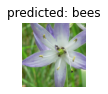

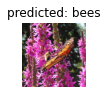

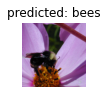

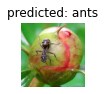

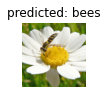

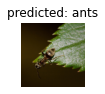

In [18]:
visualize_model(model_ft)



In [22]:
# ConvNet as fixed feature extractor

# Here, we need to freeze all the network except the final layer.
#  We need to set requires_grad == False to freeze the parameters
#   so that the gradients are not computed in backward().

model_conv = torchvision.models.resnet18(pretrained= True)

#freeze the param
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimzer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimzer, step_size=7, gamma=0.1)



In [23]:
model_conv = train_model(model_conv, criterion, optimzer, exp_lr_scheduler, num_epochs=25)

torch.save(model_conv.state_dict(), '/content/drive/My Drive/bee_ant2.pth')

Epoch 0/24
----------
train Loss: 0.7003 Acc: 0.6393
val Loss: 0.3200 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.4338 Acc: 0.7992
val Loss: 0.2168 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.5077 Acc: 0.7705
val Loss: 0.2313 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4420 Acc: 0.8074
val Loss: 0.1712 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4944 Acc: 0.7787
val Loss: 0.1923 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4588 Acc: 0.7951
val Loss: 0.1612 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.7124 Acc: 0.7295
val Loss: 0.4263 Acc: 0.8301

Epoch 7/24
----------
train Loss: 0.4547 Acc: 0.8197
val Loss: 0.2212 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2880 Acc: 0.8811
val Loss: 0.1774 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3278 Acc: 0.8361
val Loss: 0.1812 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3534 Acc: 0.8648
val Loss: 0.1643 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3007 Acc: 0.8525
val Loss: 0.1976 Acc: 0.9281

Ep

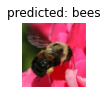

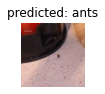

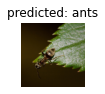

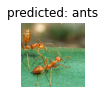

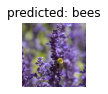

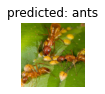

In [24]:
visualize_model(model_conv)

plt.ioff()
plt.show()